# This notebook serves as an example of how the graphs for each simulation and Active learning run were created. In this specific notebook the Enron dataset is used.

# Data importing

In [ ]:
# Load in packages
import pandas as pd                 #For data science purposes
import matplotlib.pyplot as plt     #For plotting
import os                           #For importing files directly from the disk
from email.parser import Parser     #For parsing enron emails
from tqdm import tqdm, tqdm_pandas  #For loading bars                   
import re                           #For performing regex
import numpy as np                  #For using numpy
import torch                        #For running models with cude
import string
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
import pickle                       #For importing saved variables
from keras.models import load_model #For loading in keras models
tqdm.pandas()

In [1]:
#Load in data                          

# Folder Path
path = r"C:\Users\MichaG\Documents\Scriptie\Data-main\Enron_with_categories\enron_with_categories"
  
# Change the directory
os.chdir(path)

emaillist = []
# Read text File
          
# Extract email from a txt file  
def extract_text_from_file(file_path):
    with open(file_path, 'r') as f:
        if file_path.endswith(".txt"):
            data = f.read()
            email = Parser().parsestr(data)
            body = email.get_payload()
            return body
# Extract labels from .cats file 
def extract_labels(file_path):
    with open(file_path, 'r') as f:
        if file_path.endswith(".cats"):
            return(f.read().splitlines())

# By using the above two methods, create a dataframe and extract labels and text from emails. Then concatenate these into one dataframe.        
column_names = ["abstract", "label", "length"]
enron_df = pd.DataFrame(columns = column_names)
for root, dirs, files in os.walk(r"C:\Users\MichaG\Documents\Scriptie\Data-main\Enron_with_categories\enron_with_categories"):
    for file in files:
        numericlabel, label, email, length, filename = None,None,None,None,None  # Create empty variables for storing results
        if file.endswith('.txt'):
            email = extract_text_from_file(os.path.join(root,file))
            email = ' '.join(email.split()[:len(email.split())])
            length = len(email)
            filename = file.rpartition('.')[0]
            for catfile in files:
                if catfile.endswith('.cats') and catfile.rpartition('.')[0] == file.rpartition('.')[0]:
                    numericlabel = extract_labels(os.path.join(root,catfile))
                    for labelset in numericlabel:
                        if '1,4' in labelset: #This can be changed to import whatever type of label that one would like
                            label = 1
                            break
                        elif not label == 1:
                            label = 0 
            if length < 15000 and length > 15: # Remove very long and short emails
                enron_df = pd.concat([pd.DataFrame.from_records([{'abstract': email, 'label': label, 'length' : length, 'title' : filename}]), enron_df], ignore_index=True)
        
enron_df = enron_df.astype({'label': 'int64'})

In [4]:
# The original datafile is necessary for getting the original labels
enron_df_holdout = pd.read_excel(r'C:\Users\MichaG\Documents\Scriptie\Data-main\Enron python data\enron_simulation_data_withholdout_new.xlsx', index_col=[0])

In [5]:
# Predict using active learning model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# With the following function the scores can be generated from each iteration in a more efficient manner
def generate_scores(model, y_true, X):
    predictions = []
    predictions = model.predict(X)
    accuracy = accuracy_score(y_true, predictions)
    scores = precision_recall_fscore_support(y_true, predictions)
    return [accuracy, scores[0][1], scores[1][1], scores[2][1]]




# Data Importing

In [6]:
# In this cell all relevant scores are generated from the variables that were created within ASReview. 
# First the starting point, ending point and results dataframe are created. The starting point is the first iteration and the ending point is the last iteration.
# In the results data frame the final results are stored
import pickle
starting_point = 15      
ending_point = 1400
results = pd.DataFrame(columns=['Instance','Accuracy', 'Precision', 'Recall', 'F1', 'Size'])

# Now by using the starting and ending point each variable is loaded in for every iteration and all scores are generated for every interation
for iteration in tqdm(range(starting_point, ending_point)):
    all_scores = None
    enron_df_subset = enron_df_holdout.copy()
    # open a file, where you stored the pickled data
    file = open(r'C:\Users\MichaG\Documents\Scriptie\ASReview\Simulations runs\Uncertainty+oversampling+bowfixv4\uncertaintyoversamplingbowfixv4indices' +str(iteration)+r'.pkl', 'rb')
    file1 = open(r'C:\Users\MichaG\Documents\Scriptie\ASReview\Simulations runs\Uncertainty+oversampling+bowfixv4\uncertaintyoversamplingbowfixv4alldata' +str(iteration)+r'.pkl', 'rb')
    modelfile = open(r'C:\Users\MichaG\Documents\Scriptie\ASReview\Simulations runs\Uncertainty+oversampling+bowfixv4\uncertaintyoversamplingbowfixv4model' +str(iteration)+r'.pkl', 'rb')

    # create variable using information in that file
    #model = load_model(r'C:\Users\MichaG\Documents\Scriptie\ASReview\Simulations runs\Uncertainty+oversampling+neural\uncertaintyoversamplingneuralmodel' +str(iteration)+r'.hd5')
    indices = pickle.load(file)
    data = pickle.load(file1)
    data = np.delete(data, indices, axis = 0)
    model = pickle.load(modelfile)

    enron_df_subset.drop(indices, axis=0, inplace=True)
    labels = enron_df_subset.label

    all_scores = generate_scores(model, labels, data)
    results = pd.concat([results, pd.DataFrame.from_records([{'Instance': iteration,'Accuracy': all_scores[0], 'Precision': all_scores[1], 'Recall' : all_scores[2], 'F1' : all_scores[3], 'Size':len(data)}])])
results = results.astype({'Accuracy': 'float64', 'Instance': 'int32'})
results = results.reset_index()

100%|█████████▉| 1380/1385 [00:42<00:00, 41.58it/s]C:\Users\MichaG\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████▉| 1381/1385 [00:42<00:00, 32.12it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

## Load holdout data

In [10]:
# Load in the holdout data that was created outside of ASReview
holdout_set = pd.read_excel(r'C:\Users\MichaG\Documents\Scriptie\Data-main\enron_holdoutdata.xlsx', index_col=[0])
holdout_set_ytrue = holdout_set.label
holdout_set = holdout_set.drop(['label'], axis = 1)
holdout_set_np = holdout_set.to_numpy()

In [11]:
# Generate the same scores as for the trainingdata but now for the holdoutdata
starting_point = 15
ending_point = 1400
results_holdout = pd.DataFrame(columns=['Instance','Accuracy', 'Precision', 'Recall', 'F1', 'Size'])

for iteration in tqdm(range(starting_point, ending_point)):
    all_scores_holdout = None
    modelfile = open(r'C:\Users\MichaG\Documents\Scriptie\ASReview\Simulations runs\Uncertainty+oversampling+bowfixv4\uncertaintyoversamplingbowfixv4model' +str(iteration)+r'.pkl', 'rb')
    file = open(r'C:\Users\MichaG\Documents\Scriptie\ASReview\Simulations runs\Uncertainty+oversampling+bowfixv4\uncertaintyoversamplingbowfixv4indices' +str(iteration)+r'.pkl', 'rb')
    indices = pickle.load(file)
    model = pickle.load(modelfile)
    all_scores_holdout = generate_scores(model, holdout_set_ytrue, holdout_set_np)
    results_holdout = pd.concat([results_holdout, pd.DataFrame.from_records([{'Instance': iteration,'Accuracy': all_scores_holdout[0], 'Precision': all_scores_holdout[1], 'Recall' : all_scores_holdout[2], 'F1' : all_scores_holdout[3], 'Size':len(indices)}])])
results_holdout = results_holdout.astype({'Accuracy': 'float64', 'Instance': 'int32'})
results_holdout = results_holdout.reset_index()

100%|█████████▉| 1382/1385 [00:07<00:00, 182.38it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\MichaG\\Documents\\Scriptie\\ASReview\\Simulations runs\\Uncertainty+oversampling+bowfixv4\\uncertaintyoversamplingbowfixv4model1397.pkl'

In [7]:
# Load in the reference data that was gathered from the passive learning run
data_reference = pd.read_csv(r'C:\Users\MichaG\Documents\Scriptie\Data-main\Data voor grafieken\Reference_run(Uncertainty)_simulation_set.csv', sep=';')

,Instances,Accuracy,Precision,Recall,F1-score
0,80,0.69,0.54,0.28,0.38
1,180,0.69,0.52,0.62,0.56
2,280,0.70,0.53,0.66,0.59
3,380,0.72,0.57,0.62,0.59
4,480,0.69,0.52,0.64,0.57
5,580,0.73,0.58,0.67,0.62
6,680,0.72,0.56,0.66,0.61
7,780,0.72,0.57,0.65,0.60
8,880,0.71,0.54,0.64,0.58
9,980,0.72,0.56,0.68,0.61


In [14]:
# Perform smoothing on the ASReview data
from scipy.interpolate import make_interp_spline, BSpline
xnew_acc = np.linspace(results.Instance.min(), results.Instance.max(), 300) 
spl = make_interp_spline(results.Instance, results.Accuracy, k=3) 
acc_smooth = spl(xnew_acc)

xnew_F1 = np.linspace(results.Instance.min(), results.Instance.max(), 300) 
spl_F1 = make_interp_spline(results.Instance, results['F1'], k=3) 
F1_smooth = spl_F1(xnew_F1)

#Create smooth line for holdout
xnew_acc_ho = np.linspace(results_holdout.Instance.min(), results_holdout.Instance.max(), 50) 
spl_ho = make_interp_spline(results_holdout.Instance, results_holdout.Accuracy, k=3) 
acc_smooth_ho = spl_ho(xnew_acc_ho)

xnew_F1_ho = np.linspace(results_holdout.Instance.min(), results_holdout.Instance.max(), 50) 
spl_ho_F1 = make_interp_spline(results_holdout.Instance, results_holdout['F1'], k=3) 
F1_smooth_ho = spl_ho_F1(xnew_F1_ho)

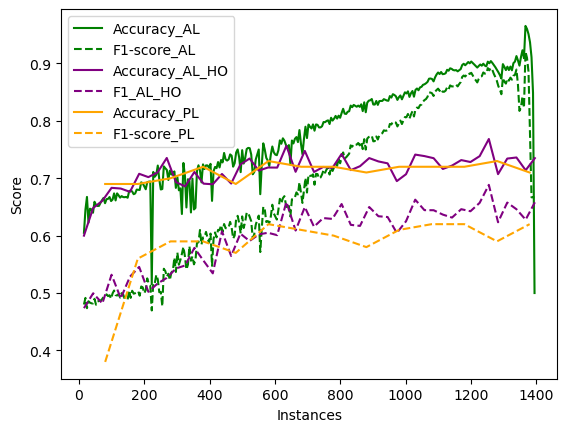

In [16]:
# plot lines
plt.plot(xnew_acc, acc_smooth, label = "Accuracy_AL", color = '#008000')
plt.plot(xnew_F1, F1_smooth, label = "F1-score_AL", linestyle='dashed', color='#008000' )
plt.plot(xnew_acc_ho, acc_smooth_ho, label = 'Accuracy_AL_HO', color = 'purple')
plt.plot(xnew_F1_ho, F1_smooth_ho, label = 'F1_AL_HO', linestyle='dashed', color = 'purple')
plt.plot(data_reference.Instances, data_reference.Accuracy, label = "Accuracy_PL", color='#ffa500')
plt.plot(data_reference.Instances, data_reference['F1-score'], label = "F1-score_PL", linestyle='dashed', color='#ffa500')
plt.legend()
plt.xlabel('Instances')
plt.ylabel('Score')
plt.show()
#plt.savefig(r'C:\Users\MichaG\Pictures\Scriptie\simulation_withholdout(Uncertainty+oversampling).pdf') # Save graph is this is necessary